# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project from Udacity's Nanodegree *Data Analyst*, I will be working to understand the results of an A/B test run by an e-commerce website. This company has developed a new web page in order to try and increase the number of users who "convert", meaning the number of users who decide to pay for the company's product. My goal here was to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

This project was already reviewed and met all the specifications. 

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` a. Now I read in the `ab_data.csv` data, store it in `df` and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df['landing_page'].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [7]:
df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [8]:
num_treat_old = len(df.query('group == "treatment" & landing_page == "old_page"'))
num_treat_old

1965

In [9]:
num_con_new = len(df.query('group == "control" & landing_page == "new_page"'))
num_con_new 

1928

In [10]:
num_treat_old + num_con_new

3893

**The total number of cases when treatment and new_page don't match are 3893:**
- **1965 cases where group was *treatment* but they saw the *old page*.**
- **1928 cases where group was *control* but they saw the *new page*.**

f. Let's see if any of the rows have missing values:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


> **No, we don't have any missing values in our dataset.**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  
a. Let's create a new dataset and store your new dataframe in **df2**.

In [12]:
df2 = df.drop(df[(df['group'] == "treatment") & (df['landing_page'] == "old_page") | (df['group'] == "control") & (df['landing_page'] == "new_page")].index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Now we are going to explore the duplicated users in df2. 

a. How many unique **user_id**s are in **df2**?

In [14]:
df2.user_id.nunique()

290584

In [15]:
len(df2.user_id)

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
sum(df2.user_id.duplicated())


1

In [17]:
duplicated_user_ids = list(df2[df2.duplicated(subset = 'user_id', keep = False)]['user_id'])
duplicated_user_ids[0]

773192

c. What is the row information for the repeat **user_id**? 

In [18]:
df2[df2.duplicated(subset = 'user_id', keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. We are going to remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
#Get the index of one of the duplicated rows
id_dup = list(df2[df2.duplicated(subset = 'user_id')].index)[0]
df2.drop([id_dup], inplace = True)

sum(df2.user_id.duplicated())

0

`4.` a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
p_population = len(df2.query('converted == 1')) / df2.shape[0]
p_population

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
p_control = len(df2.query('group == "control" & converted == 1')) / len(df2.query('group == "control"'))
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
p_treatment = len(df2.query('group == "treatment" & converted == 1')) / len(df2.query('group == "treatment"'))
p_treatment

0.11880806551510564

In [23]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [24]:
len(df2.query('landing_page == "new_page"')) / df2.shape[0]

0.5000619442226688

e. Is there sufficient evidence to say that the new treatment page leads to more conversions?

> **Considering these results, it seems that individuals from treatment group convert less often than the control group. Given that, I would not say that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Though we could recommend to keep running tests, now we are going to assume that we have to make the decision just based on all the data provided.  I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, so these are my null and alternative hypotheses:

$H_{0}: p_{new} - p_{old} \leq 0$

$H_{1}: p_{new} - p_{old} > 0$

`2.` Under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, let's assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We are going to use a sample size for each page equal to the ones in **ab_data.csv** and then perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [25]:
p_new_null = p_population
p_new_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [26]:
p_old_null = p_population
p_old_null

0.11959708724499628

c. What is $n_{new}$?

In [27]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$?

In [28]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Let's simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = np.random.choice([0, 1], size = n_new, p=[1-p_new_null, p_new_null])
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

f. Let's simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null and store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [1 - p_old_null, p_old_null])
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Now we can find $p_{new}$ - $p_{old}$ for our simulated values.

In [31]:
p_new_converted = new_page_converted.mean()
p_old_converted = old_page_converted.mean()
diff_null = p_new_converted - p_old_converted
diff_null

0.0016426986325315251

h. Let's now simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process and dtore all 10,000 values in a numpy array called **p_diffs**.

In [32]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p=[1-p_new_null, p_new_null])
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [1 - p_old_null, p_old_null])
    diff_null = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff_null)

i. We can plot a histogram of the **p_diffs** and include the line for **obs_diff**. 

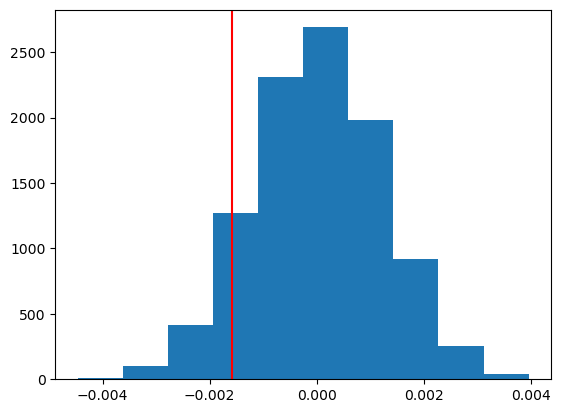

In [33]:
plt.hist(p_diffs);
plt.axvline(x = obs_diff, color = "red");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
p_diffs = np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.9026

k. What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **This value is p value. Given that this p value (90%) is greater than the type I error rate (5%), we cannot reject the null hypothesis that the old page is better.**

l. We could also use a built-in to achieve similar results.  Now we calculate the number of conversions for each page, as well as the number of individuals who received each page.

In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('group == "control" & converted == 1'))

# number of conversions with the new_page
convert_new = len(df2.query('group == "treatment" & converted == 1'))

# number of individuals who were shown the old_page
n_old = len(df2.query('group == "control"'))

# number of individuals who received new_page
n_new = len(df2.query('group == "treatment"'))

In [36]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now we can use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is the link used for it.

In [37]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


<a id='regression'></a>
### Part III - A regression approach

`1.` The result I acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should I be performing in this case?

> **We want to predict whether there is a conversion or not, so there are only two possible outcomes. This means we should work with a logistic regression.**

b. My goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.  I will add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [39]:
df2 = df2.drop("control", axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Let's use **statsmodels** to import my regression model.  I will instantiate the model, and fit the model to predict whether or not an individual converts.

In [40]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Below I provide the summary of my model.

In [41]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2023-02-12 13:09 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value I found in **Part II**?<br><br>  

> **The p-value associated with ab_page is 0.1899. It does differ from the p-value found in Part II because it does not refer to the same model.**
> - **The null hypotheses associated with this regression model is that the ab_page variable cannot predict whether a user converts or not. The alternative hypotheses states that the ab_page variable can predict it. So these are two-sided hypothesis.** 
> - **The null hypotheses associated with Part II was one-sided. The alternative hypotheses was that the converted rate of the new page was greater than the converted rate of the old page.**
> - **Given the Type I error rate of 5%, we also fail to reject the null hypotheses from this regression model. It does not seem that the ab_page variable (old or new page) can predict whether a person converts or not.**

f. I shall consider other things that might influence whether or not an individual converts, but is it a good idea to consider other factors to add into my regression model?

>**Sometimes it is a good idea to add additional terms into the regression model. It may be useful if you want to understand how all variables are related or if you want to make predictions about the response (convert).**
>**Nevertheless, it is important to know that the more variables you add to your model, the more problems you may face: correlation of error terms, outliers, multicollinearity, etcetera.**

g. Now along with testing if the conversion rate changes for different pages, also I want to add an effect based on which country a user lives. So I will read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 

In [42]:
df_countries = pd.read_csv('countries.csv')
df_merged = df2.join(df_countries.set_index('user_id'), on = 'user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [43]:
df_merged['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [44]:
### Now I create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [45]:
#Fit my model
logit_mod2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'CA']])
results2 = logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2023-02-12 13:09 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
==================================================================

"""

Does it appear that country had an impact on conversion? 

> **It does not appear that country had an impact on conversion. It seems that it does not explain the conversion and p-values associated with countries are not statistically significant.**

h. We could now like to look at an interaction between page and country to see if there significant effects on conversion.

In [46]:
# Creating the new interaction variable in a new column.
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']

df_merged.sample(5)


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_ab_page,UK_ab_page,CA_ab_page
280994,668886,2017-01-04 05:11:57.774692,treatment,new_page,0,1,1,US,0,0,1,1,0,0
166749,939834,2017-01-13 03:06:42.732448,control,old_page,0,1,0,US,0,0,1,0,0,0
62185,904322,2017-01-14 14:57:43.339584,treatment,new_page,0,1,1,US,0,0,1,1,0,0
142524,691997,2017-01-16 10:42:48.250235,treatment,new_page,0,1,1,US,0,0,1,1,0,0
221901,659735,2017-01-03 20:03:39.674533,control,old_page,0,1,0,US,0,0,1,0,0,0


In [47]:
# Fitting my model, and summarizing the results
lm3 = sm.OLS(df_merged['converted'], df_merged[['intercept', 'UK_ab_page', 'CA_ab_page', 'US_ab_page']])
results3 = lm3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.351
Date:                Sun, 12 Feb 2023   Prob (F-statistic):             0.0702
Time:                        13:09:11   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
UK_ab_page     0.0008      0.002      0.411      0.681      -0.003       0.005
CA_ab_page    -0.0085      0.004     -2.180      0.029      -0.016      -0.001
US_ab_page    -0.0019      0.001     -1.449      0.147      -0.005       0.001
==============================================================================
Omnibus:                   125549.632   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414287.274
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         7.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>**In this last model, we have that the interaction between page (old or new) and Canada (but not other countries) is statistically significant (0.03). 
Nevertheless, we must say that this interaction is difficult to interpret and there may be no reason to use this regression model to explain the relationship between user's country and conversion (via group). 
Provide the summary results (statistical output), and your conclusions (written response) based on the results.**

<a id='conclusions'></a>
## Conclusions

**According to the statistical tests performed, including the Z-test, the logistic regression model, and the observed difference, the results indicate that there is no significant difference in the conversion rate between the new and old page. Therefore, the null hypothesis cannot be rejected. Based on these findings, it is recommended that the company maintain the use of the old page, as this will result in a reduction of time and expenses associated with developing a new page.**